In [1]:
import tensorflow as tf
import numpy as np
import numpy.random as rng
import pandas as pd
import os, pdb, re
import string
import stats
import keras.preprocessing.text as text
from keras.preprocessing import sequence
from keras import utils
float_formatter = lambda x: "%.3f" % x
np.set_printoptions(linewidth=200,threshold=np.nan,formatter={'float_kind':float_formatter})
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option("display.max_colwidth",200)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#Preprocessing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

/Users/matt/kaggle/movie_sent/venv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /Users/matt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
MAX_WORD_COUNT = 60
N_OUT = 5
BATCH_SIZE = 5
HIDDEN_SIZE = 8
NUM_LAYERS = 2
INIT_SCALE = 0.05

In [3]:
fx = lambda x: pd.read_csv(x,delimiter="\t",header=0)
train_df,test_df = map(fx, ["train.tsv","test.tsv"])
feat_names = train_df.columns.values
#train_df.head()

# Get full sentences from data set

In [4]:
def group_max(group):
    idx = np.where(group["Phrase"].apply(len)==group["Phrase"].apply(len).max())[0][0]
    return group["Phrase"].iloc[idx]
df = train_df.groupby("SentenceId").apply(group_max).values
#remove_stop = lambda sentence: [word for word in sentence if word not in stopwords.words('english')]

# The Love Song of J. Alfred Prufrock

In [5]:
df = pd.read_table("The Love Song of J. Alfred Prufrock.txt",header=None,names=["Line"],dtype={"Line":str})
txt = df["Line"].values
txt = ' \n '.join([''.join(row) for row in txt]).lower()
txt = re.sub(r'[^\w\s]',' ',txt)
df_clean = txt.split("\n")

In [6]:
df_clean_yellow = list(filter(lambda row: "yellow" in row,df_clean))
df_clean_will = list(filter(lambda row: "will" in row,df_clean))
df_clean = np.concatenate((df_clean_will,df_clean_yellow))

In [29]:
class Data_obj():
    def __init__(self,batch_size,clean_data):
        self.epoch = 1
        self.i = self.k = 0
        self.batch_size = batch_size
        self.clean_data = clean_data
        
        self.Tokenizer = text.Tokenizer()
        self.Tokenizer.fit_on_texts(self.clean_data)
        self.words = self.Tokenizer.word_index.keys()
        self.encoded_text = self.Tokenizer.texts_to_sequences(self.clean_data)
        
        self.inverse_tokenizer = lambda num: list(self.Tokenizer.word_index.keys())[list(self.Tokenizer.word_index.values()).index(num)] #inverse
        self.inverse_tokenizer_sentence = lambda sentence: list(map(self.inverse_tokenizer,sentence))
        
        self.vocab_size = len(self.Tokenizer.word_index) + 1
        print("There are {0} unique words in data set.".format(self.vocab_size))
        
    def shuffle(self):
        rng.shuffle(self.encoded_text)
        
    def new_batch(self):
        return np.zeros((self.batch_size,2)).astype(np.int32)
    
    def generator(self):
        self.shuffle()
        batch = self.new_batch()
        self.total_examples_seen = 0
        while True:
            
            self.current_sentence = self.encoded_text[self.i]
            sentence_len = len(self.current_sentence)
            if sentence_len < 2:
                self.i += 1
                continue
            for j in range(sentence_len):
                context = self.current_sentence[j]

                if j == 0:
                    target = self.current_sentence[j+1]
                elif j == sentence_len - 1:
                    target = self.current_sentence[j-1]
                elif rng.uniform() < 0.5:
                    target = self.current_sentence[j-1]
                else:
                    target = self.current_sentence[j+1]

                batch[self.k,0] = context
                batch[self.k,1] = target
                if self.k == BATCH_SIZE - 1:
                    self.k = 0
                    yield batch
                    batch = self.new_batch()
                    self.total_examples_seen += self.batch_size
                else:
                    self.k += 1
            self.i+=1
            if self.i == len(self.encoded_text):
                self.epoch += 1
                self.i = 0
                self.shuffle()  #shuffle after epoch
                

In [30]:
data_obj = Data_obj(batch_size=BATCH_SIZE,clean_data=df_clean)
generate_batch = data_obj.generator()

There are 56 unique words in data set.


In [31]:
for i in range(5):
    data = next(generate_batch)
    print(data_obj.current_sentence,data_obj.inverse_tokenizer_sentence(data_obj.current_sentence))
    for i in data:
        print(i,data_obj.inverse_tokenizer_sentence(i))

[16, 32, 3, 33, 34, 35, 36, 1, 37] ['for', 'decisions', 'and', 'revisions', 'which', 'a', 'minute', 'will', 'reverse']
[16 32] ['for', 'decisions']
[32 16] ['decisions', 'for']
[ 3 32] ['and', 'decisions']
[33 34] ['revisions', 'which']
[34 33] ['which', 'revisions']
[2, 9, 48, 7, 18, 19, 49, 50, 2, 20, 21] ['the', 'yellow', 'fog', 'that', 'rubs', 'its', 'back', 'upon', 'the', 'window', 'panes']
[35 34] ['a', 'which']
[36  1] ['minute', 'will']
[ 1 37] ['will', 'reverse']
[37  1] ['reverse', 'will']
[2 9] ['the', 'yellow']
[2, 9, 48, 7, 18, 19, 49, 50, 2, 20, 21] ['the', 'yellow', 'fog', 'that', 'rubs', 'its', 'back', 'upon', 'the', 'window', 'panes']
[ 9 48] ['yellow', 'fog']
[48  7] ['fog', 'that']
[ 7 48] ['that', 'fog']
[18 19] ['rubs', 'its']
[19 18] ['its', 'rubs']
[2, 9, 48, 7, 18, 19, 49, 50, 2, 20, 21] ['the', 'yellow', 'fog', 'that', 'rubs', 'its', 'back', 'upon', 'the', 'window', 'panes']
[49 50] ['back', 'upon']
[50 49] ['upon', 'back']
[ 2 20] ['the', 'window']
[20 21] ['w

## Embedding layer - Turns positive integers (indexes) into dense vectors of fixed size”

In [48]:
def old():
    #NUM_STEPS = MAX_WORD_COUNT
    train_inputs = tf.placeholder(tf.int32,shape=[None])
    train_labels = tf.placeholder(tf.int32,shape=[None,1])
    embeddings = tf.Variable(tf.random_uniform([data_obj.vocab_size, HIDDEN_SIZE])) # NUmber of words by hidden
    embed = tf.nn.embedding_lookup(embeddings, train_inputs) #lookup action on the embedding tensor, where each word in the input data set is matched with a row in the embedding tensor, with the matched embedding vector being returned within inputs.

    #loss
    num_sampled = 5
    nce_weights = tf.Variable(
      tf.truncated_normal([vocab_size, HIDDEN_SIZE],
                          stddev=1.0 / np.sqrt(HIDDEN_SIZE)))
    nce_biases = tf.Variable(tf.zeros([vocab_size]))
    logits = tf.reduce_sum(tf.multiply(embeddings,nce_weights),1) + nce_biases
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocab_size))

    learning_rate = tf.placeholder(tf.float32,shape=[1])
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
    saver = tf.train.Saver()

In [71]:

train_inputs = tf.placeholder(tf.int32,shape=[None])
train_labels = tf.placeholder(tf.int32,shape=[None,1])
embeddings = tf.Variable(tf.random_uniform([data_obj.vocab_size, HIDDEN_SIZE])) # NUmber of words by hidden
embed = tf.nn.embedding_lookup(embeddings, train_inputs) #lookup action on the embeddin

In [72]:
weights = tf.Variable(tf.truncated_normal([data_obj.vocab_size, HIDDEN_SIZE],
                          stddev=1.0 / np.sqrt(HIDDEN_SIZE)))
biases = tf.Variable(tf.zeros([data_obj.vocab_size]))
logits = tf.reduce_sum(tf.multiply(embeddings, weights), 1) + biases

In [73]:
loss = tf.reduce_mean(tf.nn.nce_loss(weights=weights,
                 biases=biases,
                 labels=train_labels,
                 inputs=embed,
                 num_sampled=num_sampled,
                 num_classes=vocab_size))
learning_rate = tf.placeholder(tf.float32,shape=[1])
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
saver = tf.train.Saver()

In [80]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    embeddings_before = embeddings.eval()
    data_obj = Data_obj(batch_size=BATCH_SIZE,clean_data=df_clean)
    generate_batch = data_obj.generator()
    cur_losses = []
    lr = np.array([0.5])
    while True:
        data = next(generate_batch)
        feed_dict = {train_inputs: data[:,0],train_labels:data[:,[1]],learning_rate:lr}
        _, cur_loss = sess.run([optimizer, loss], feed_dict=feed_dict)
        cur_losses.append(cur_loss)
        if data_obj.total_examples_seen % 1000 == 0:
            print("{0} seen with running loss of {1:.3f}. Current epoch = {2}. Current lr = {3:.3f}".format(data_obj.total_examples_seen,np.mean(cur_losses),data_obj.epoch,lr[0]))
            cur_losses = []
            lr /= 1.01
        if data_obj.epoch == 150:
            print("Finished.")
            break
    save_path = saver.save(sess, "/tmp/model.ckpt")
    idx = np.arange(1,vocab_size)
    learnt_embed = embed.eval(feed_dict={train_inputs:idx})
    learnt_embeddings = embeddings.eval()

There are 56 unique words in data set.
0 seen with running loss of 12.461. Current epoch = 1. Current lr = 0.500
1000 seen with running loss of 3.437. Current epoch = 10. Current lr = 0.495
2000 seen with running loss of 1.900. Current epoch = 19. Current lr = 0.490
3000 seen with running loss of 1.567. Current epoch = 29. Current lr = 0.485
4000 seen with running loss of 1.411. Current epoch = 38. Current lr = 0.480
5000 seen with running loss of 1.270. Current epoch = 48. Current lr = 0.476
6000 seen with running loss of 1.188. Current epoch = 57. Current lr = 0.471
7000 seen with running loss of 1.165. Current epoch = 67. Current lr = 0.466
8000 seen with running loss of 1.155. Current epoch = 76. Current lr = 0.462
9000 seen with running loss of 1.069. Current epoch = 85. Current lr = 0.457
10000 seen with running loss of 1.111. Current epoch = 95. Current lr = 0.453
11000 seen with running loss of 1.064. Current epoch = 104. Current lr = 0.448
12000 seen with running loss of 1.095

In [81]:
pd.DataFrame(df_clean)

,0
0,and indeed there will be time
1,there will be time there will be time
2,there will be time to murder and create
3,and indeed there will be time
4,they will say how his hair is growing thin
5,they will say but how his arms and legs are thin
6,for decisions and revisions which a minute will reverse
7,am an attendant lord one that will do
8,i do not think that they will sing to me
9,the yellow fog that rubs its back upon the window panes


In [82]:
print(learnt_embeddings.shape)
learnt_embeddings

(56, 8)


array([[0.595, 0.349, 0.308, 0.090, 0.509, 0.067, 0.197, 0.815],
       [1.769, 0.488, 0.035, 1.587, 1.276, -0.089, 0.315, 0.143],
       [0.459, 0.353, 1.120, 1.208, -0.909, 2.130, 1.791, 0.689],
       [1.184, 1.211, 2.710, -1.107, 1.455, 0.648, 0.088, 0.086],
       [0.327, 0.388, 1.646, 0.376, 1.016, 1.240, -0.726, 1.733],
       [0.407, -0.741, 1.834, 1.422, 0.762, 1.124, 0.333, 1.884],
       [0.768, 0.850, 1.137, 2.208, 2.670, 0.013, 1.188, -0.570],
       [1.433, 0.867, 0.435, 1.190, -0.504, 0.112, -0.336, 2.376],
       [0.120, 0.246, 0.020, 1.408, 1.877, 1.873, -0.662, 1.665],
       [2.612, 1.641, 0.566, 0.699, -0.411, 1.252, -0.970, 1.430],
       [0.507, 2.790, 0.425, 2.895, 0.883, -0.270, -0.129, 0.581],
       [2.457, -1.232, 2.515, 0.547, 0.539, 0.555, 1.143, 0.402],
       [0.199, 0.976, 1.493, 0.163, 2.015, -0.972, 0.802, 2.611],
       [1.058, 2.650, -0.726, 0.050, 2.018, -0.675, 1.708, 1.427],
       [0.857, 0.919, 2.058, -0.026, 0.889, -0.625, 2.983, -0.158],
     

In [ ]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    #saver.restore(sess, "/tmp/model.ckpt")
    print(nce_weights.eval())

In [89]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    #saver.restore(sess, "/tmp/model.ckpt")
    print(nce_weights.eval())
    for word in data_obj.Tokenizer.word_index.keys():
        word_no = data_obj.Tokenizer.word_index[word]
        print(word,word_no)
        logits_ = logits.eval(feed_dict={train_inputs:np.array([word_no])})
        print(logits_)
        #top_n = 5
        #top_targets = logits_.argsort()[:top_n]
        #print(top_targets)
        #print(data_obj.inverse_tokenizer_sentence(top_targets))

[[0.244 0.071 0.271 0.435 -0.591 0.513 0.058 -0.395]
 [-0.328 -0.165 -0.353 -0.066 0.413 -0.374 -0.663 0.356]
 [0.157 0.172 -0.092 -0.300 -0.211 0.070 -0.318 -0.107]
 [0.239 -0.348 -0.386 -0.556 0.079 0.120 0.160 0.600]
 [-0.335 0.236 -0.018 -0.521 0.136 -0.664 0.037 0.445]
 [0.280 -0.208 0.580 -0.249 0.058 -0.149 0.272 -0.272]
 [0.342 -0.014 0.410 -0.306 0.309 0.044 -0.270 0.342]
 [-0.347 0.202 0.211 -0.039 -0.448 -0.098 0.672 -0.204]
 [-0.206 -0.016 0.175 0.541 0.088 0.260 0.011 -0.147]
 [0.686 -0.686 0.047 -0.320 -0.352 0.390 0.049 -0.452]
 [0.378 -0.414 -0.650 -0.415 0.169 -0.479 0.097 0.427]
 [-0.511 0.132 0.021 0.170 -0.340 0.121 0.144 0.170]
 [-0.259 -0.364 -0.327 -0.113 0.441 -0.155 -0.233 0.267]
 [-0.299 0.108 0.439 0.183 0.349 0.318 0.102 -0.553]
 [0.202 -0.086 -0.257 -0.576 0.006 0.282 0.689 0.010]
 [-0.552 0.124 -0.202 -0.664 0.196 -0.435 -0.544 -0.643]
 [0.093 0.426 0.072 0.360 0.548 0.099 -0.485 0.102]
 [-0.185 0.069 -0.067 -0.417 0.618 -0.071 0.241 -0.475]
 [0.607 -0.168

In [46]:
dim_reduction = TSNE(n_components=2)
X_embedded = dim_reduction.fit_transform(learnt_embed)
labels = data_obj.inverse_tokenizer_sentence(idx)

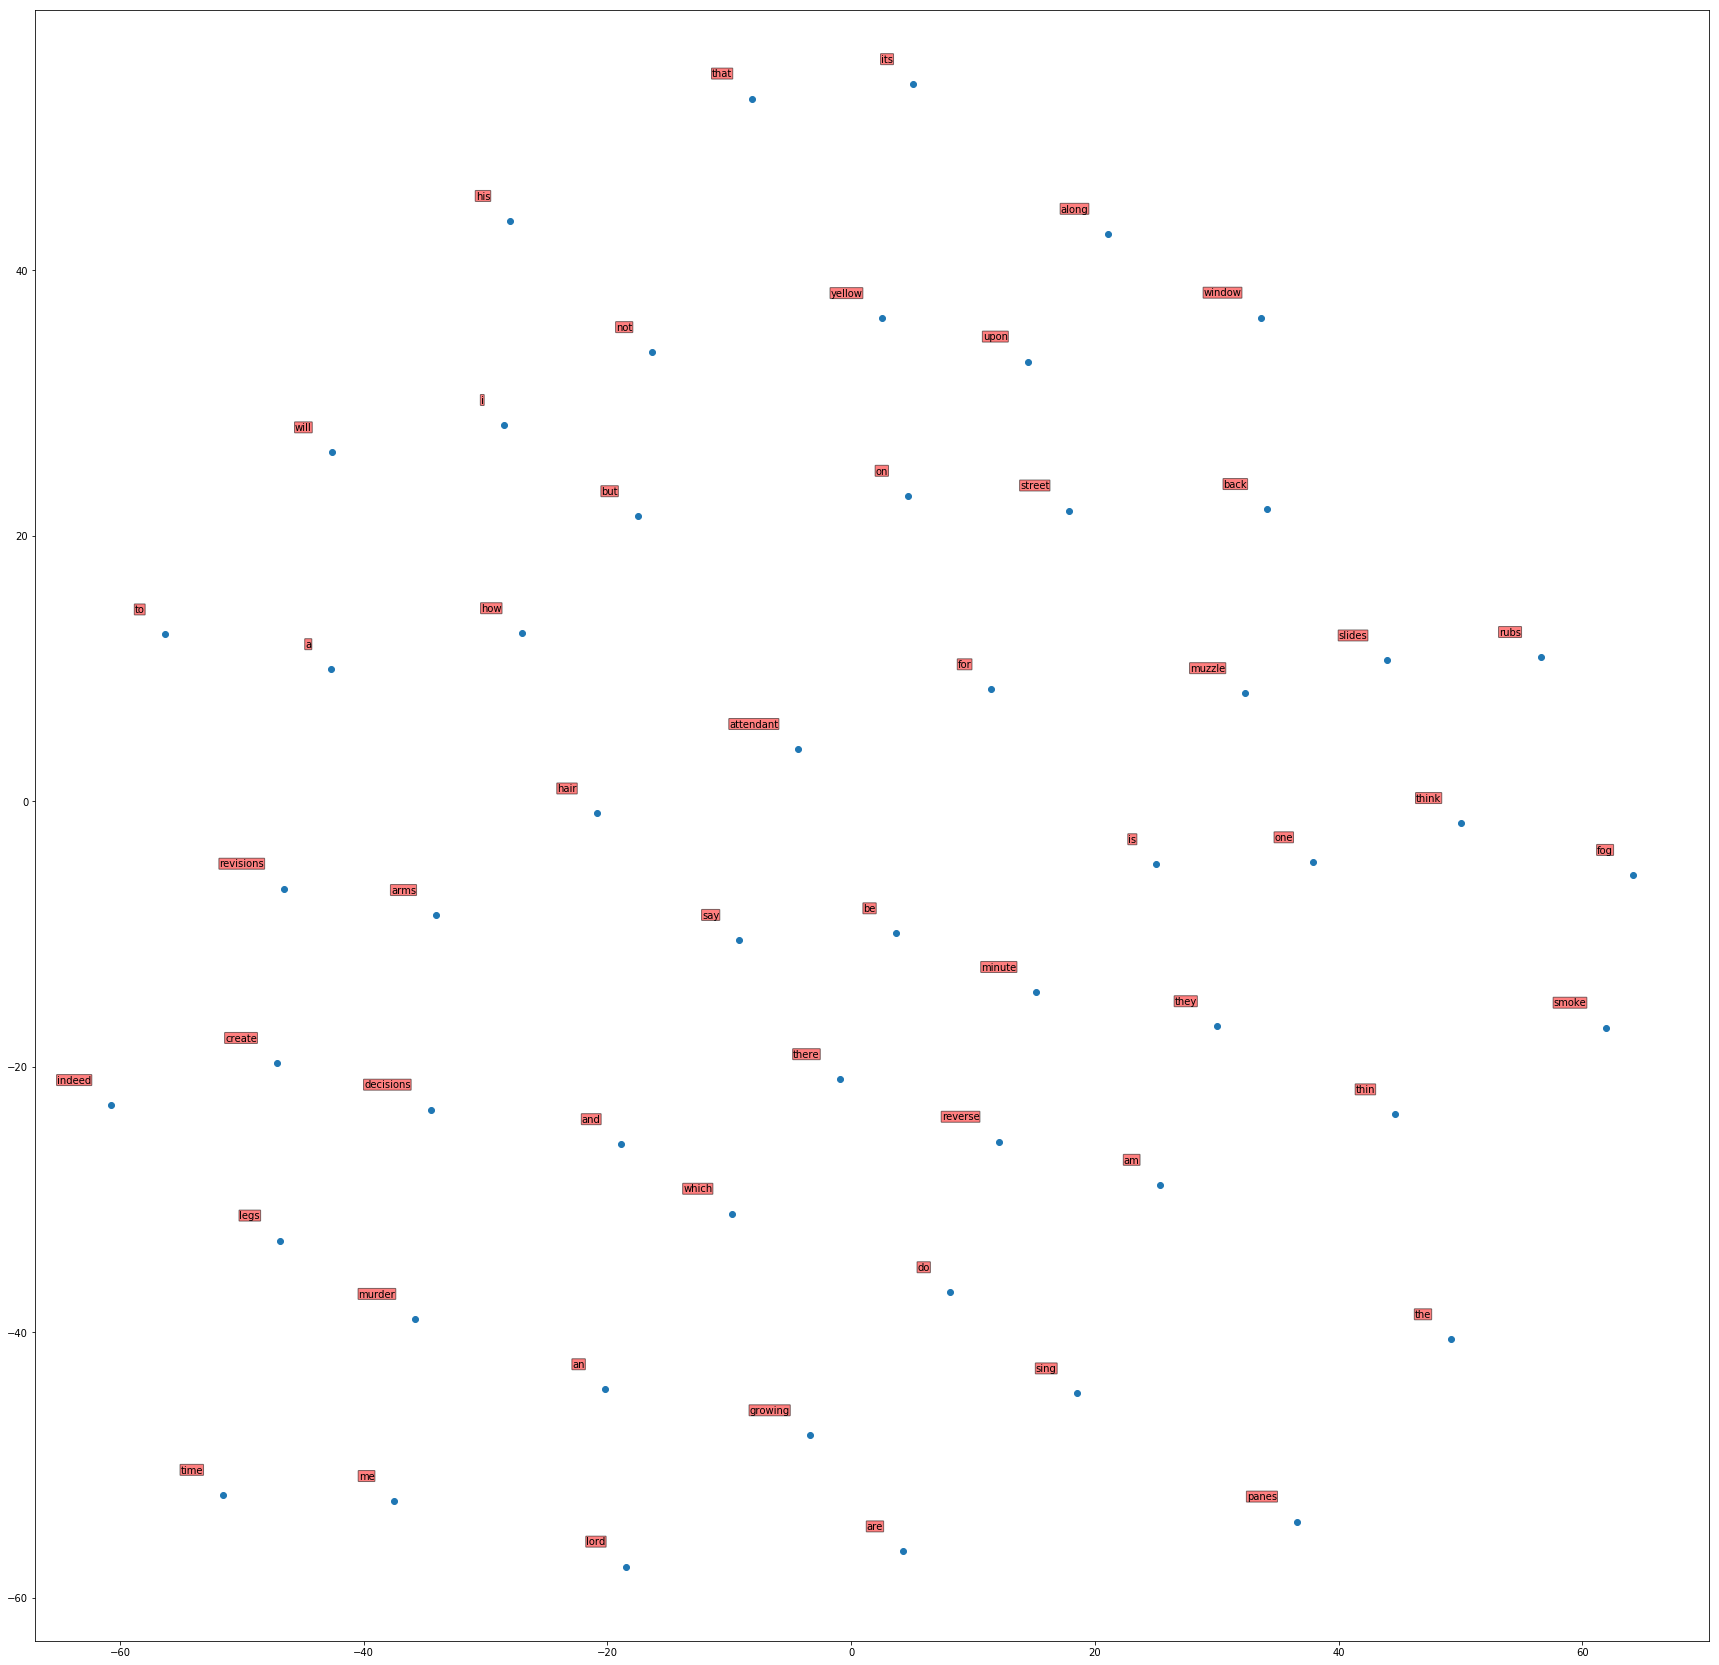

In [47]:
plt.figure(figsize=(30,30))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='o',
    cmap=plt.get_cmap('Spectral'))
for label, x, y in zip(labels, X_embedded[:, 0], X_embedded[:, 1]):
    color = "yellow" if label in ("have","been","seen") else "red"
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.05', fc=color, alpha=0.5))
        #arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))